# Reconocimiento de Comandos de Voz
---
**Configuración General del Entorno de Trabajo**

Esta sección detecta si el notebook está corriendo en un entorno COLAB o en uno LOCAL . Monta la carpeta de Google Drive si corresponde y define constantes para trabajar de forma general con cualquir script. Modificar las definiciones de las carpetas según el entorno y configuración del mismo.

In [23]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
    LOCAL_DIR = './DATOS/'  # carpeta local en maquina virtual
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '../FUENTES'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = '../DATOS/' # carpeta donde se encuentran los datasets
    LOCAL_DIR = DATOS_DIR

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


---
### Preparación de Dataset


In [24]:
import zipfile
import os

# Ruta al archivo ZIP en Google Drive
zip_path = os.path.join(DATOS_DIR, 'Voz-Espectros.zip')

# Ruta de destino para la extracción (carpeta local)
extract_dir = LOCAL_DIR

# Verificar si el archivo ZIP existe
if not os.path.exists(zip_path):
    print(f"Error: El archivo {zip_path} no existe.")
else:
    # Crear la carpeta de destino si no existe
    os.makedirs(extract_dir, exist_ok=True)

    # Descomprimir el archivo ZIP
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"Archivo descomprimido exitosamente en: {extract_dir}")
    except zipfile.BadZipFile:
        print("Error: El archivo ZIP está corrupto o no es válido.")
    except Exception as e:
        print(f"Ocurrió un error al descomprimir: {str(e)}")

Archivo descomprimido exitosamente en: ./DATOS/


**Preparación de Datos**

In [25]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPooling2D,Activation,Flatten,Dropout,Dense, Input, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import skimage.io as io
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import glob

def import_data(img_list):
    img_data = []
    label_data = []

    img_count = len(img_list)
    for i in range(0,img_count):
        img = img_list[i]
        img_read = io.imread(img)

        img_read = img_read/img_read.max() # normaliza pixeles entre 0 y 1
        img_read = img_read.reshape((*img_read.shape,1))

        #img_read = img_read[:,:,0]         # extrae 1er canal porque estan en escala de grises
        #img_read = img_read.flatten()      # redefine como arreglo de 1 dimension
        img_data.append(img_read)          # agrega a lista de imágenes a procesar
        label_data.append(img[img.rindex('_')+1:-4])         # extrae texto de la palabra desde el nombre del archivo
        # muestra progreso en la carga
        if i % 100 == 0:
            print("\rCargando imágenes (%d): %6.2f%%" % (i,100*i/img_count), end="")
    print("\rCargando imágenes (%d): 100.00%%\n" % i)

    return np.array(img_data), np.array(label_data)


IMG_ERROR = 'No hay imágenes para cargar. Verificar que la ruta sea correcta y que la carpeta tenga imagenes con la extensión usada'

# %% Carga imágenes de entrenamiento y testeo desde las carpetas

# lista de archivos para entrenamiento

train_img_list = glob.glob(LOCAL_DIR + 'Espectros/Train/*.png')
assert len(train_img_list) > 0, IMG_ERROR

# carga las imagenes a partir de los nombres de archivos
xtrain, yraw = import_data(train_img_list)

# %% Establece parámetros de entrenamiento

# tamano de imagen extraido de los datos
IMG_SIZE = (xtrain.shape[1], xtrain.shape[2],1)


# cantidad de pasadas de los datos
EPOCAS = 200
# cantidad de datos a procesar para actualizar pesos
LOTES  = 300

# %% binariza valores del target

# conviertes el id de la clase en "one hot encoding": clase 3 => [0,0,0,1,0,0]
# Binarizador para convertir el nombre de la clase en one hot encoding
binarizador = preprocessing.LabelBinarizer()
ytrain= binarizador.fit_transform(yraw)


# cantidad de clases
# N_CLASSES = len(np.unique(yraw))
CLASES  = binarizador.classes_

# %% Separa los datos y clase en grupo de entrenamiento y validacion
x_train, x_val, y_train, y_val = train_test_split(xtrain, ytrain, test_size = 0.10, shuffle=True)

Cargando imágenes (10281): 100.00%



**Contrucción del Modelo**

In [26]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def build_model(img_size, classes):
    model = Sequential()

    # La forma de entrada debe ser (height, width, channels)
    model.add(Input(shape=img_size))  # img_size ya debe incluir los canales (ej: (96, 96, 3))

    # Bloque 1: CONV => LeakyReLU => BN => POOL
    model.add(Conv2D(16, (5, 5), strides=(1,1), padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # Bloque 2
    model.add(Conv2D(32, (3, 3), strides=(1,1), padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # Bloque 3
    model.add(Conv2D(32, (3, 3), strides=(1,1), padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # Bloque 4
    model.add(Conv2D(64, (3, 3), strides=(1,1), padding="same"))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # Bloque 5
    model.add(Conv2D(64, (3, 3), strides=(1,1), padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # Capas Fully Connected
    model.add(Flatten())
    model.add(Dense(32))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.3))
    model.add(Dense(classes, activation='softmax'))

    return model

# Verifica la forma de IMG_SIZE y CLASES antes de construir el modelo
print(f"Tamaño de imagen: {IMG_SIZE}")
print(f"Número de clases: {len(CLASES)}")

# Obtiene la arquitectura para el modelo y lo compila
model = build_model(IMG_SIZE, len(CLASES))
model.summary()

# Compilación
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Tamaño de imagen: (64, 65, 1)
Número de clases: 14


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 64, 65, 16)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 64, 65, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_20 (LeakyReLU)      │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_21 (LeakyReLU)      │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_22 (LeakyReLU)      │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 2, 2, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 79,246 (309.55 KB)

 Trainable params: 78,830 (307.93 KB)

 Non-trainable params: 416 (1.62 KB)

**Entrenamiento de Modelo**

In [27]:
# %% Entrena el modelo

es = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001, restore_best_weights=True)

# entrena el modelo y guarda la historira del progreso
H=model.fit(x = x_train, y = y_train, batch_size = LOTES, epochs = EPOCAS,
          validation_data = (x_val, y_val), callbacks=[es])


Epoch 1/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.3040 - loss: 2.2193 - val_accuracy: 0.0777 - val_loss: 2.6352
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7486 - loss: 0.8878 - val_accuracy: 0.1399 - val_loss: 2.6019
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8283 - loss: 0.5953 - val_accuracy: 0.1380 - val_loss: 2.6297
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8721 - loss: 0.4286 - val_accuracy: 0.0894 - val_loss: 2.6885
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.9003 - loss: 0.3364 - val_accuracy: 0.1011 - val_loss: 2.6254
Epoch 6/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9167 - loss: 0.2731 - val_accuracy: 0.1710 - val_loss: 2.6385
Epoch 7/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.9383 - loss: 0.2065 - val_accuracy: 0.2585 - val_loss: 2.5249
Epoch 8/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9494 - loss: 0.1844 - val_accuracy: 0.3518 - v

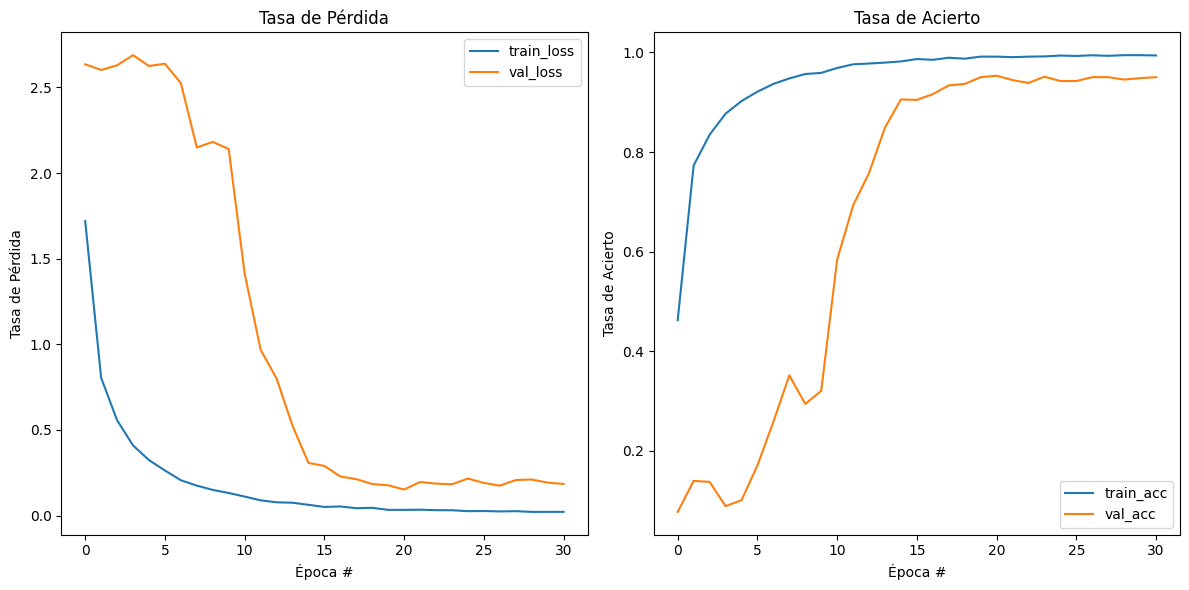

In [28]:
# Crea una figura con dos subgráficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 fila, 2 columnas

# Gráfico 1: Tasa de pérdida (Loss)
ax1.plot(H.history["loss"], label="train_loss")
ax1.plot(H.history["val_loss"], label="val_loss")
ax1.set_title("Tasa de Pérdida")
ax1.set_xlabel("Época #")
ax1.set_ylabel("Tasa de Pérdida")
ax1.legend(loc="upper right")

# Gráfico 2: Tasa de acierto (Accuracy)
ax2.plot(H.history["accuracy"], label="train_acc")
ax2.plot(H.history["val_accuracy"], label="val_acc")
ax2.set_title("Tasa de Acierto")
ax2.set_xlabel("Época #")
ax2.set_ylabel("Tasa de Acierto")
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()

Cargando imágenes (6348): 100.00%

290/290 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step
              precision    recall  f1-score   support

        CERO       1.00      1.00      1.00       655
       CINCO       1.00      1.00      1.00       670
      CUATRO       1.00      1.00      1.00       667
         DOS       1.00      1.00      1.00       671
     FIREFOX       1.00      1.00      1.00       575
         HEY       1.00      1.00      1.00       640
          NO       1.00      1.00      1.00       678
       NUEVE       1.00      1.00      1.00       647
        OCHO       1.00      1.00      1.00       684
        SEIS       1.00      1.00      1.00       671
          SI       1.00      1.00      1.00       685
       SIETE       1.00      1.00      1.00       672
        TRES       1.00      1.00      1.00       669
         UNO       1.00      1.00      1.00       669

    accuracy                           1.00      9253
   macro avg  

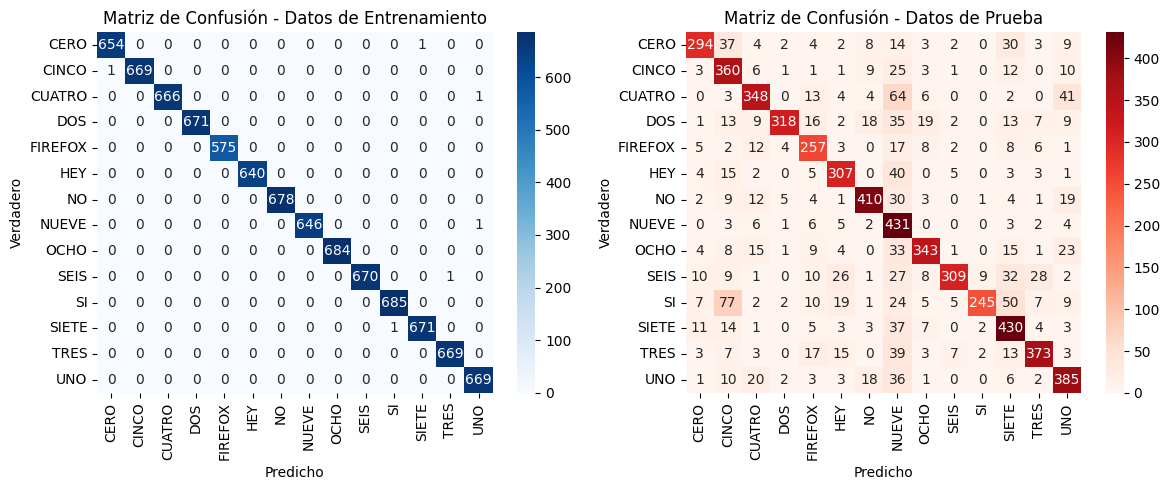

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

def evaluar(x_data, y_data, bin_tr):
    y_pred = model.predict(x_data)
    y_pred_lbl = bin_tr.inverse_transform(y_pred)
    y_data_lbl = bin_tr.inverse_transform(y_data)
    conf_mt = confusion_matrix(y_data_lbl, y_pred_lbl)
    acc = (y_pred_lbl == y_data_lbl).sum()/len(y_data_lbl)
    report = classification_report(y_data_lbl, y_pred_lbl)
    return (acc, conf_mt, report)

# Verificación con datos de testeo
img_list = glob.glob(LOCAL_DIR + 'Espectros/Test/*.png')
assert len(img_list) > 0, IMG_ERROR

# Carga las imágenes a partir de los nombres de archivos
x_test, y_raw = import_data(img_list)
y_test = binarizador.transform(y_raw)

# Evalua el modelo en datos de entrenamiento y datos de prueba
(acc_train, conf_mt_train, report_train) = evaluar(x_train, y_train, binarizador)
(acc_test, conf_mt_test, report_test) = evaluar(x_test, y_test, binarizador)

# Crear una figura con dos subgráficos uno al lado del otro
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico 1: Matriz de confusión para datos de entrenamiento con Seaborn
sns.heatmap(conf_mt_train, annot=True, fmt='d', cmap='Blues', ax=ax1, xticklabels=CLASES, yticklabels=CLASES)
ax1.set_title('Matriz de Confusión - Datos de Entrenamiento')
ax1.set_xlabel('Predicho')
ax1.set_ylabel('Verdadero')
print(report_train)

# Gráfico 2: Matriz de confusión para datos de prueba con Seaborn
sns.heatmap(conf_mt_test, annot=True, fmt='d', cmap='Reds', ax=ax2, xticklabels=CLASES, yticklabels=CLASES)
ax2.set_title('Matriz de Confusión - Datos de Prueba')
ax2.set_xlabel('Predicho')
ax2.set_ylabel('Verdadero')
print(report_test)

plt.tight_layout()
plt.show()